In [2]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


%matplotlib inline

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric




data_path_write = 'C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Time_predictions_on_selected_attributes\\'
data_path_write2 = 'C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\All_pre-prediction_attributes\\'
#fa = pd.read_csv(data_path)
#entire_dataset = pd.read_csv(data_path2)

Function to pick which data to perform time prediction analysis on. 1 is for emails received, 2 is all gmail data, 3 is the five attributes

In [3]:
def pick_your_poison(number):
    if (number == 1):
        df = pd.read_csv("C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\cbt.csv")
        print("You picked cbt.csv")
        return df
    if (number == 2):
        df = pd.read_csv("C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\gmail_df.csv")
        print("You picked overall data")
        return df
    if (number == 3):
        df = pd.read_csv("C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\gmail_df.csv")
        df = df[['time','emails_received','emails_sent','inbound_rejected_emails','inbound_spam_emails','inbound_non_spam_emails']]
        print("The five attributes")
        return df
    if(number == 4):
        df = pd.read_csv("C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Time_predictions_on_5_attributes\\" + metric_name + ".csv")
        return df
    else:
        df = []
        print("No dataset for you")
    return df
    

Function to pass column time as a date time object and set time as an index. It is important for plotting

In [4]:
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df = df.set_index(df.columns[0])
    return df


Function to plot the predicted values and the original data

In [5]:
def plot(df,df0, time):
    #Plt.plot requires the index to be a time series, if the df index is not a time series then this if condition will set it
    if(time == True):
        df1 = df.copy()
        df2 = df0.copy()
        df1 = time_set(df1)
        df2 = time_set(df2)
    elif(time == False):
        df1 = df.copy()
        df2 = df0.copy()
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22, 10))
        plt.plot(df1.index, df1[df1.columns[x]], label=df1.columns[x])
        plt.plot(df2.index, df2[df2.columns[x]], label='Prophet', color='r')
        plt.legend(loc='best', fontsize='xx-large')
        plt.show()

Function to do time prediction

In [98]:
def timeprediction123(df,csvfilename, cpscale):
    p = Prophet(weekly_seasonality=True, seasonality_mode='multiplicative',seasonality_prior_scale = 7, changepoint_prior_scale=cpscale)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    

    #df3 = df1
    #df3 = df3.rename(columns={df3.columns[0]: "time", df3.columns[1]: csvfilename})
    #df3 = cap_neg(df3)
    #df3.to_csv(data_path_write + csvfilename + "_prediction" + ".csv", index = True)
    df2 = time_pred[['yhat']]
    print(csvfilename)
    p.plot(time_pred)
    p.plot_components(time_pred)
    return df1,df2,time_pred

Includes MAPE graph

In [78]:
def timepredictionMAPE(df,csvfilename,cpscale):
    p = Prophet(weekly_seasonality=True, yearly_seasonality = True,seasonality_prior_scale = 7, seasonality_mode='multiplicative', changepoint_prior_scale=cpscale)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    
    df3 = df1
    df3 = df3.rename(columns={df3.columns[0]: "time", df3.columns[1]: csvfilename})
    df3 = cap_neg(df3)
    
    df_cv = cross_validation(p, initial='730 days', period='180 days', horizon = '365 days')
    
    df_p = performance_metrics(df_cv)

    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())
    
    fig = plot_cross_validation_metric(df_cv, metric='mape')
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

Function to send all columns in a dataframe to timeprediction123

In [131]:
def send_prediction(df,cpscale):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1],cpscale = cpscale)[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1],cpscale = cpscale)[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [132]:
def send_predictionMAPE(df,cpscale):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1],cpscale = cpscale)[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1], cpscale = cpscale)[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

This function basically reindexes the original dataset and fills 0s with predicted values. If it finds any negative values then it caps it at 0

In [147]:
def fill_zero(df1, pred):
    df1 = time_set(df1)
    pred = time_set(pred)
    pred = pred.apply(np.ceil)
    
    idx = pd.date_range('03-23-2015', '08-17-2019')
    df1 = df1.reindex(idx, fill_value = 0)
    pred = cap_neg(pred,True)
    for x in range(len(df1.columns)):
        for j in range(len(df1)):
            if(df1[df1.columns[x]].iloc[j] == 0):
                df1[df1.columns[x]].iloc[j] = pred[pred.columns[x]].iloc[j]
    
        
    return df1,pred


    

This function caps all negative values to 0 in the prediction

In [144]:
def cap_neg(df, isTimeSeries):
        if(isTimeSeries == False):
            df[df.columns[1:]] = df[df.columns[1:]].apply(np.ceil).copy()
            df = time_set(df)
        elif(isTimeSeries == True):
            df= df.apply(np.ceil).copy()

        #for x in range(len(df.columns)):
         #   for j in range(len(df)):
          #          if(df[df.columns[x]].iloc[j] < 0 ):
           #             df[df.columns[x]].iloc[j] = df[df.columns[x]].iloc[j] = 0
        df[df < 0] = 0        
        return df 

This function makes a csv for each attr in the dataframe

In [162]:
def print_each_attr(df, isTimeSeries):
    df1 = df.copy()
    if(isTimeSeries == False):
        df1 = time_set(df1)
            
    df1 = cap_neg(df1, True)   
    for x in range (len(df1.columns)):
        n = df1[[df1.columns[x]]]
        n.to_csv(data_path_write + df1.columns[x] + "_prediction.csv", index = True)

In [12]:
def drop_zero(df):
    df = df[(df != 0).all(1)]
    print(df.min())
    
    return df
        

Time prediction actually begins here

In [24]:
five_att = pick_your_poison(3)

The five attributes


In [25]:
five_att = drop_zero(five_att)

time                       2015-03-23 00:00:00-04:00
emails_received                                74919
emails_sent                                     1181
inbound_rejected_emails                            1
inbound_spam_emails                             9578
inbound_non_spam_emails                        50814
dtype: object


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


emails_received


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


emails_sent


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


inbound_rejected_emails


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


inbound_spam_emails


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


inbound_non_spam_emails


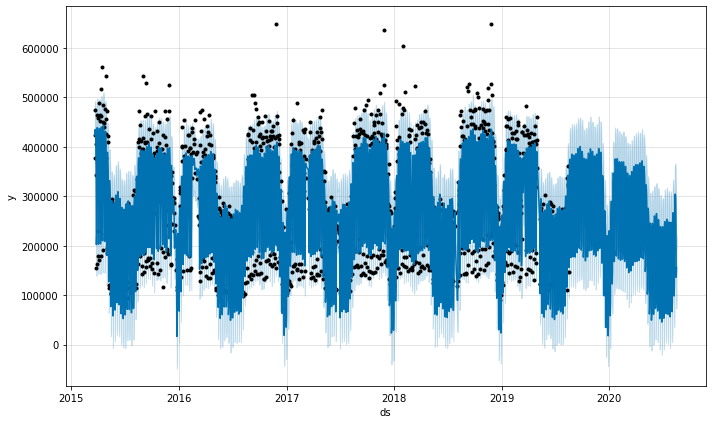

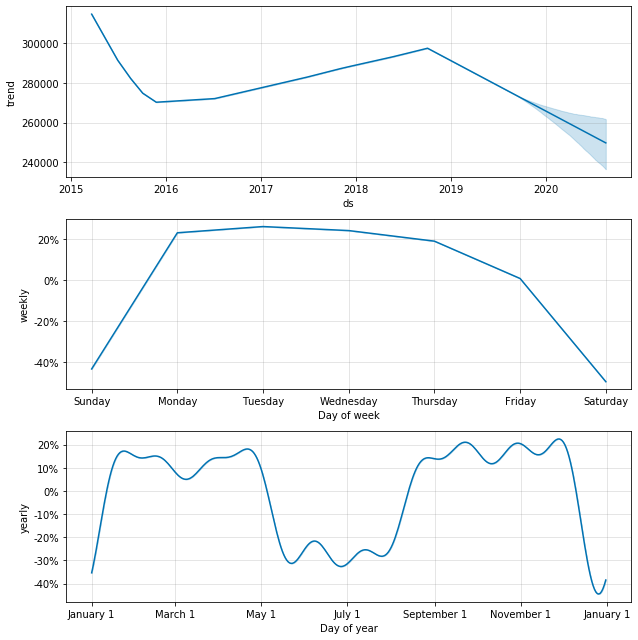

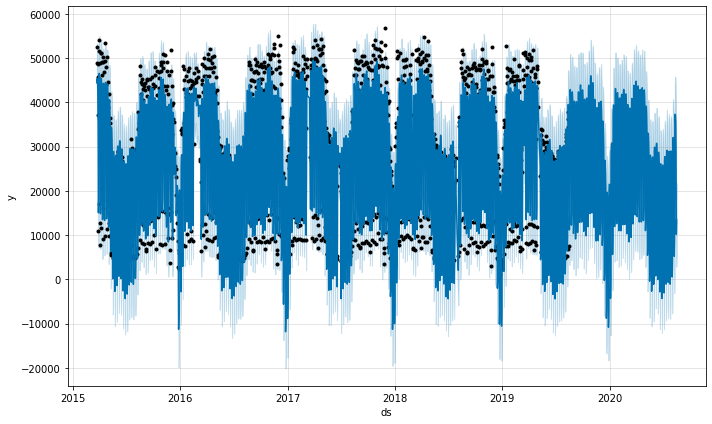

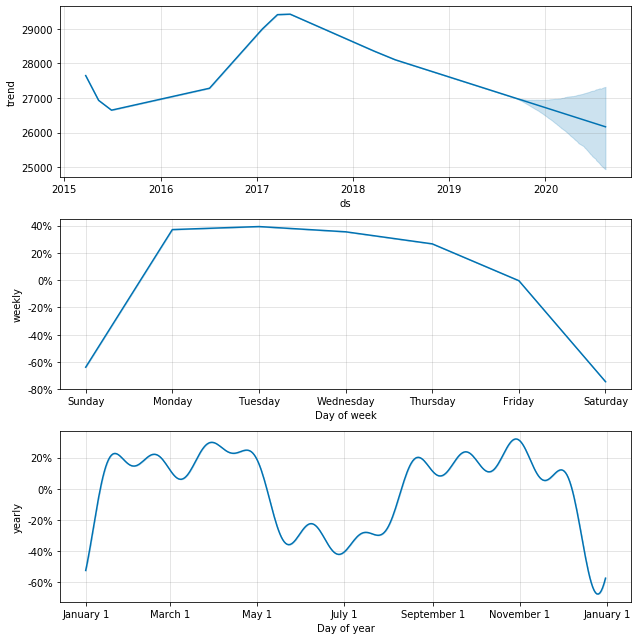

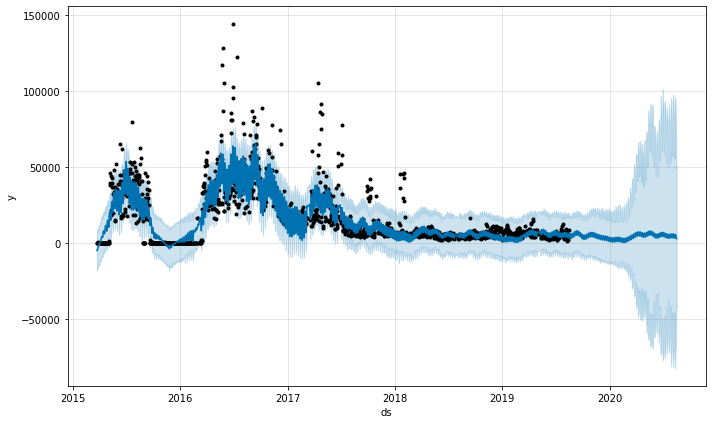

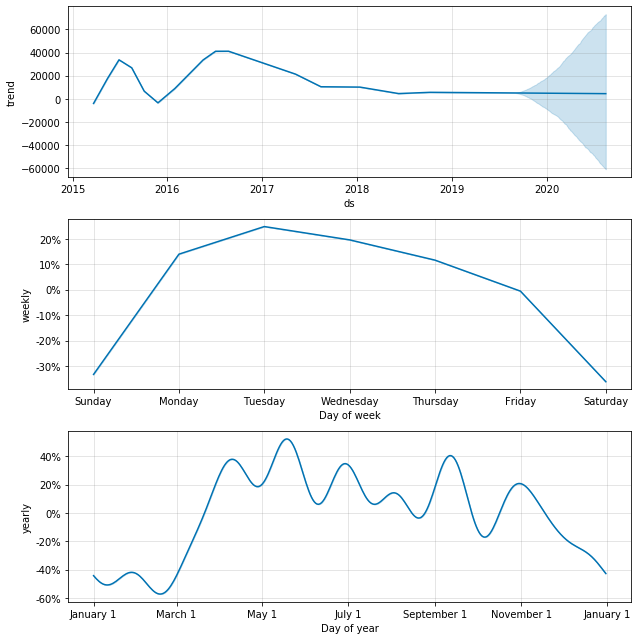

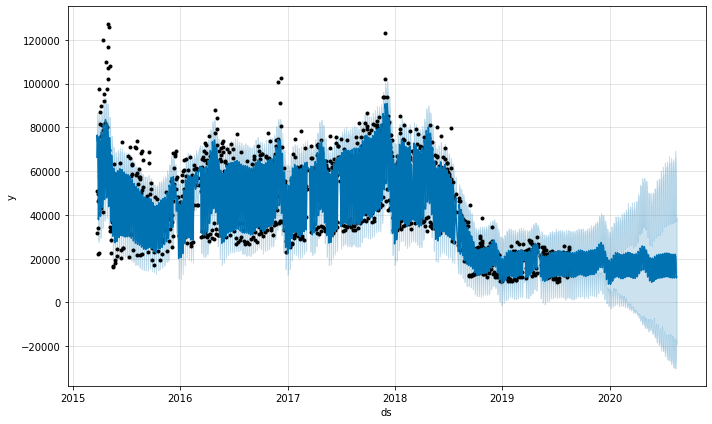

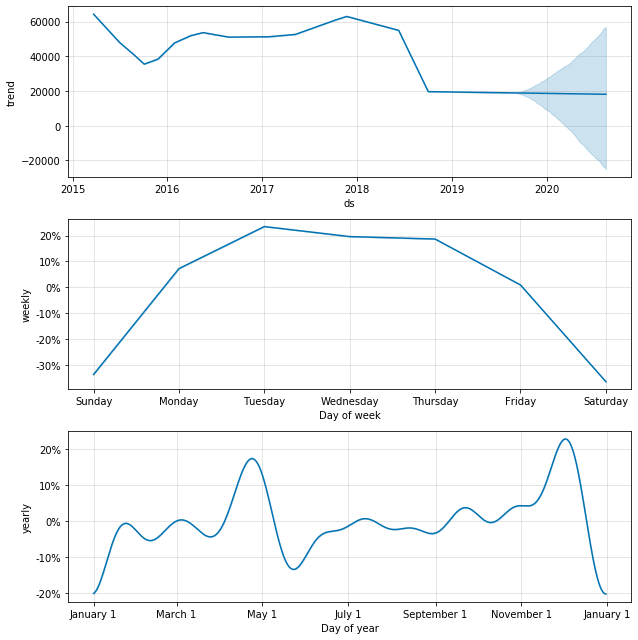

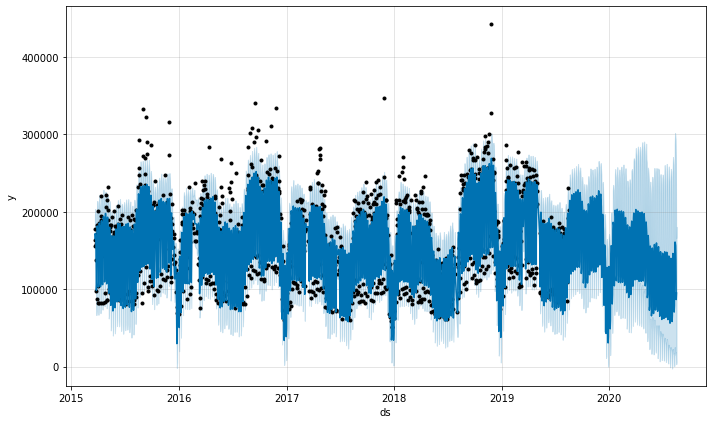

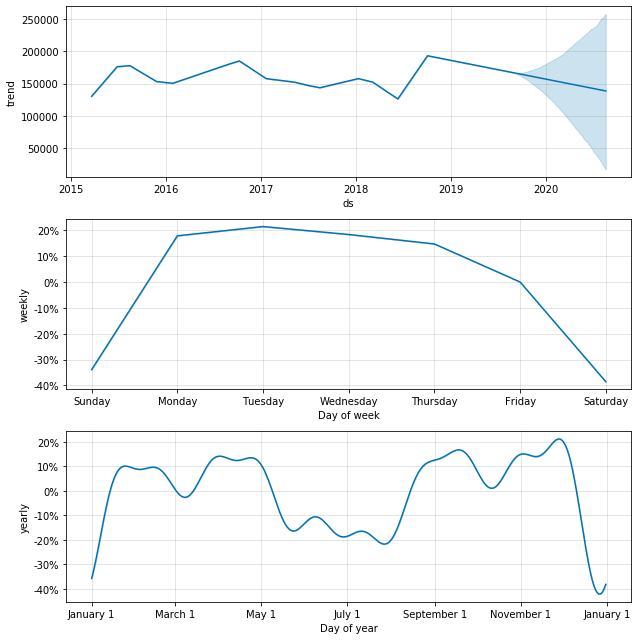

In [133]:
prediction = send_prediction(five_att, 0.25)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_received
  horizon           mse          rmse           mae      mape  coverage
0 37 days  3.260516e+09  57100.924733  42307.053901  0.155694  0.816993
1 38 days  3.291394e+09  57370.671597  42895.121891  0.157137  0.823529
2 39 days  3.309081e+09  57524.611370  43203.083864  0.158333  0.823529
3 40 days  3.480716e+09  58997.591021  43816.226681  0.162705  0.816993
4 41 days  3.481128e+09  59001.085243  43822.978663  0.163593  0.813725
Performance tail for emails_received
     horizon           mse          rmse           mae      mape  coverage
324 361 days  3.584375e+09  59869.652758  45975.004454  0.190015  0.915033
325 362 days  3.556289e+09  59634.626931  45562.840243  0.186929  0.921569
326 363 days  3.649189e+09  60408.521403  46094.214602  0.187626  0.924837
327 364 days  3.681589e+09  60676.101222  46112.338373  0.185640  0.931373
328 365 days  3.844085e+09  62000.687969  47022.902513  0.185017  0.931373


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_sent
  horizon           mse         rmse          mae      mape  coverage
0 37 days  4.638425e+07  6810.598206  4902.593061  0.268007  0.882353
1 38 days  4.639826e+07  6811.626849  4922.988784  0.268187  0.882353
2 39 days  4.641275e+07  6812.690357  4940.908083  0.272575  0.882353
3 40 days  5.144649e+07  7172.620908  5108.156480  0.287225  0.872549
4 41 days  5.187900e+07  7202.707775  5148.220403  0.294951  0.872549
Performance tail for emails_sent
     horizon           mse         rmse          mae      mape  coverage
324 361 days  2.716700e+07  5212.197156  3822.050255  0.239919  0.950980
325 362 days  2.660776e+07  5158.271193  3738.468108  0.225116  0.950980
326 363 days  2.754524e+07  5248.356118  3808.934315  0.224090  0.950980
327 364 days  2.769617e+07  5262.714621  3835.455076  0.223266  0.950980
328 365 days  2.778826e+07  5271.457144  3867.273257  0.220368  0.954248


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_rejected_emails
  horizon           mse         rmse          mae      mape  coverage
0 37 days  3.554732e+07  5962.157197  3839.692981  0.530443  0.980392
1 38 days  3.733940e+07  6110.597019  3987.181747  0.545984  0.980392
2 39 days  3.909580e+07  6252.663397  4134.911173  0.562362  0.980392
3 40 days  4.814492e+07  6938.653895  4537.221446  0.590116  0.970588
4 41 days  5.846469e+07  7646.220690  4895.615927  0.610099  0.960784
Performance tail for inbound_rejected_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  4.219908e+08  20542.413922  16355.416857  3.328091       1.0
325 362 days  4.116866e+08  20290.061580  16199.429520  3.329774       1.0
326 363 days  4.128738e+08  20319.295128  16201.022653  3.325961       1.0
327 364 days  4.211713e+08  20522.458036  16300.907857  3.327388       1.0
328 365 days  4.314465e+08  20771.290060  16457.006328  3.330992       1.0


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_spam_emails
  horizon           mse          rmse           mae      mape  coverage
0 37 days  1.557064e+08  12478.236532   9771.748011  0.333472  0.647059
1 38 days  1.611156e+08  12693.133067   9926.070271  0.342374  0.640523
2 39 days  1.682686e+08  12971.837372  10090.515974  0.351602  0.640523
3 40 days  1.751753e+08  13235.380248  10316.319470  0.361868  0.640523
4 41 days  1.758770e+08  13261.862735  10341.550379  0.360881  0.637255
Performance tail for inbound_spam_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  1.191661e+09  34520.440215  25815.882420  1.317976  0.650327
325 362 days  1.184800e+09  34420.921096  25704.925122  1.307032  0.660131
326 363 days  1.163021e+09  34103.093825  25470.497444  1.306302  0.660131
327 364 days  1.148807e+09  33894.058497  25395.586309  1.311309  0.660131
328 365 days  1.158881e+09  34042.341809  25556.895248  1.314088  0.660131


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00


Performance head for inbound_non_spam_emails
  horizon           mse          rmse           mae      mape  coverage
0 37 days  1.697778e+09  41204.106504  33566.161107  0.199499  0.571895
1 38 days  1.783280e+09  42228.900155  34358.972211  0.202204  0.552288
2 39 days  1.859973e+09  43127.401473  35001.776675  0.205470  0.542484
3 40 days  1.985250e+09  44556.141853  36365.832112  0.216803  0.522876
4 41 days  2.039996e+09  45166.312073  37093.303574  0.223637  0.509804
Performance tail for inbound_non_spam_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  4.707354e+09  68610.157366  62998.263860  0.406560  0.562092
325 362 days  4.745930e+09  68890.709277  63218.954017  0.405360  0.558824
326 363 days  5.055021e+09  71098.671259  64732.427701  0.408251  0.545752
327 364 days  5.272380e+09  72611.159047  65821.021948  0.409753  0.542484
328 365 days  5.511382e+09  74238.679460  67144.476519  0.412070  0.532680


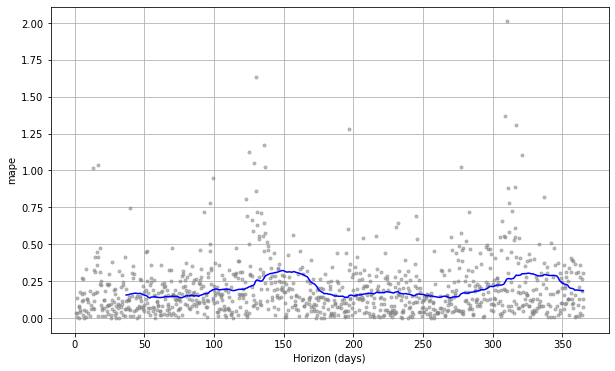

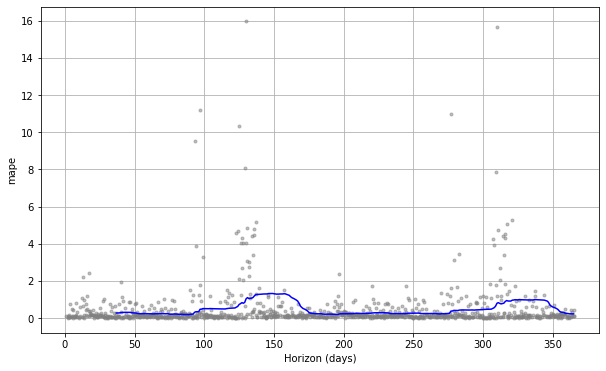

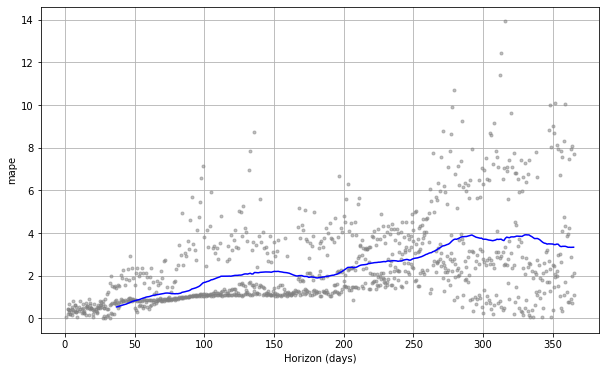

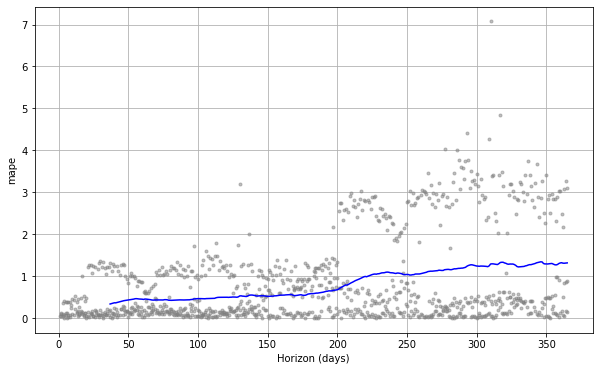

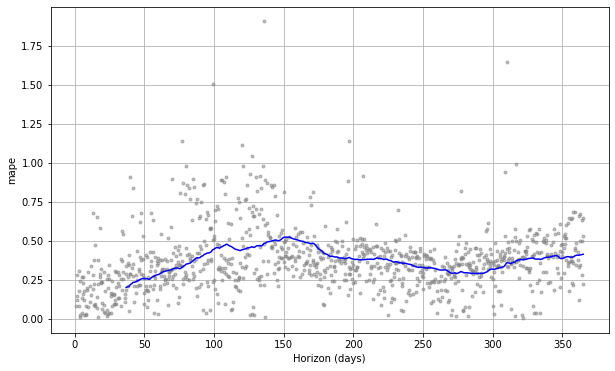

In [79]:
prediction1 = send_predictionMAPE(five_att,0.25)

In [136]:
print_each_attr(prediction,False)

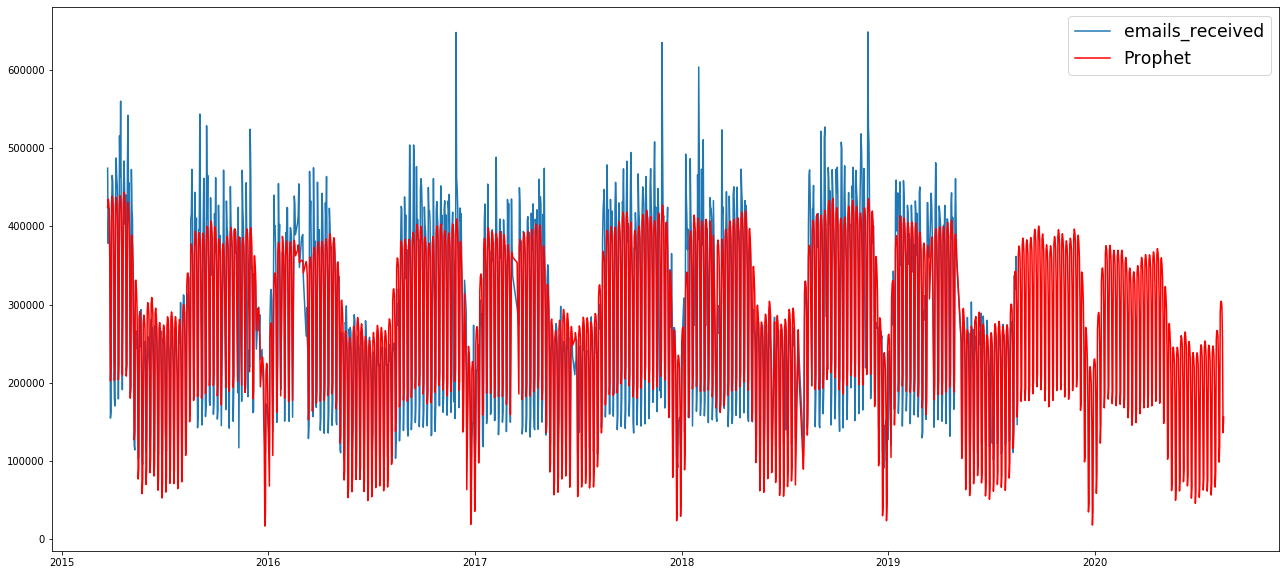

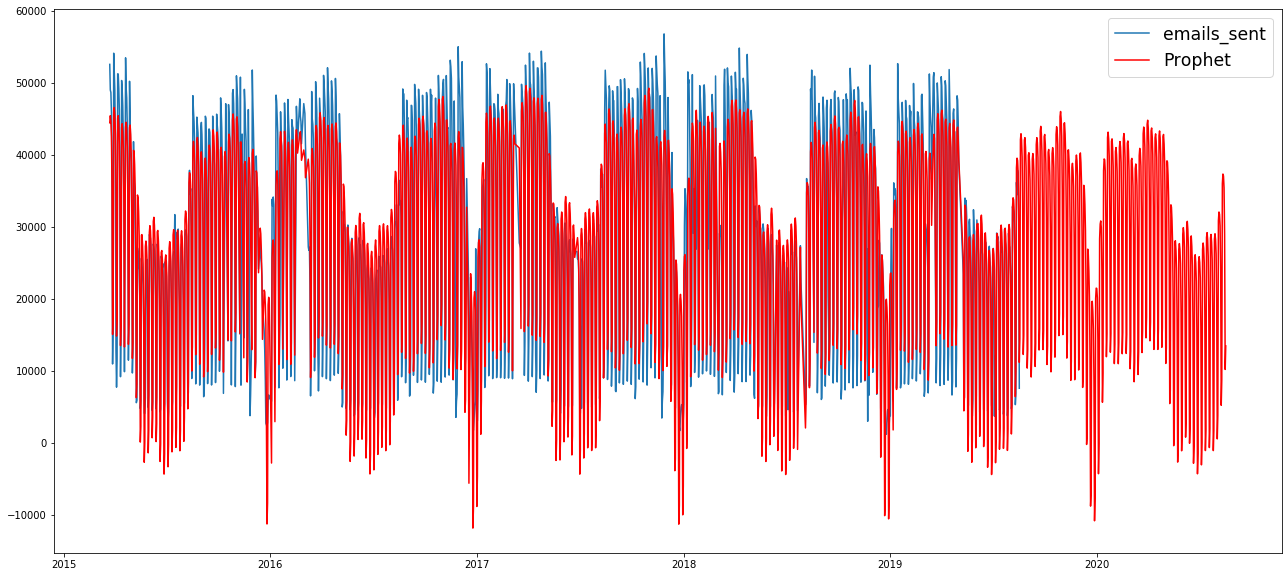

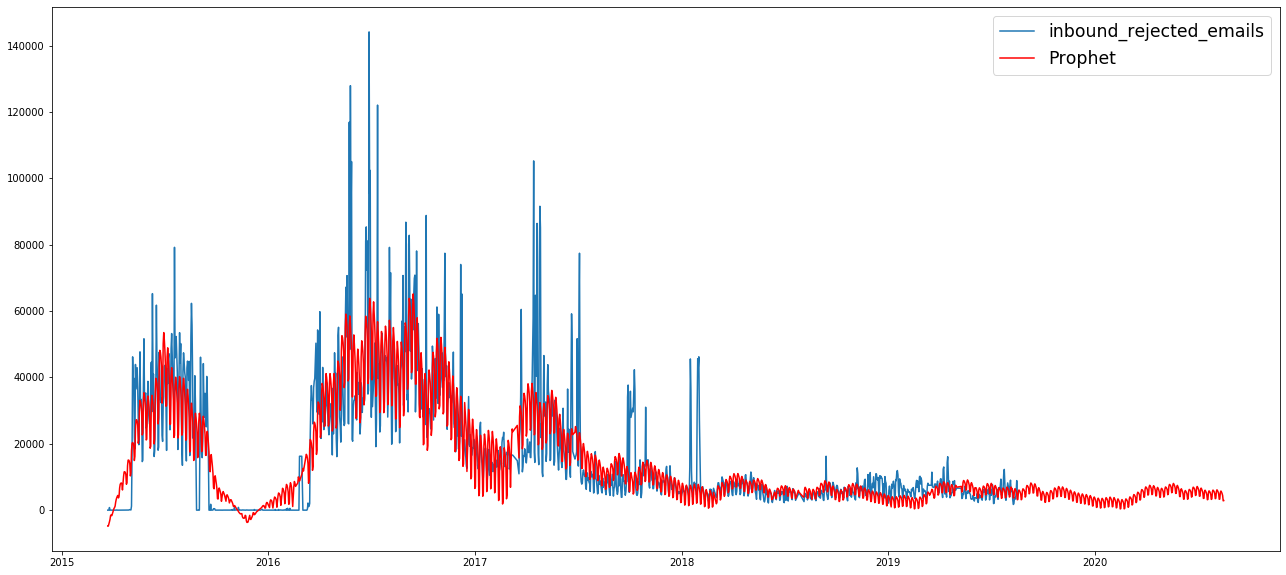

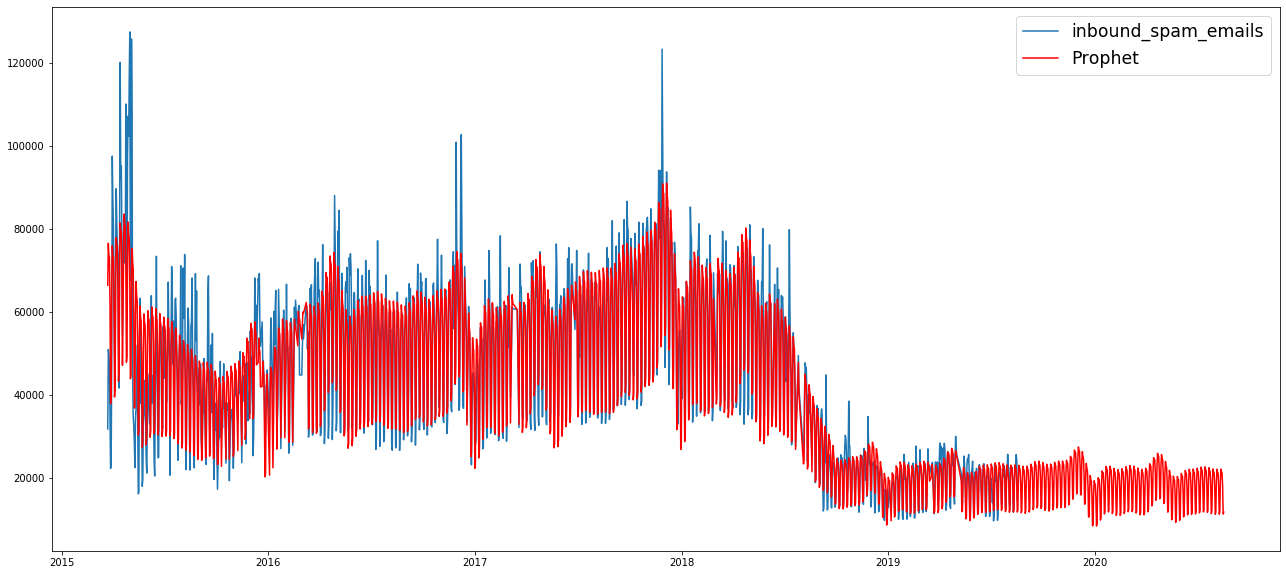

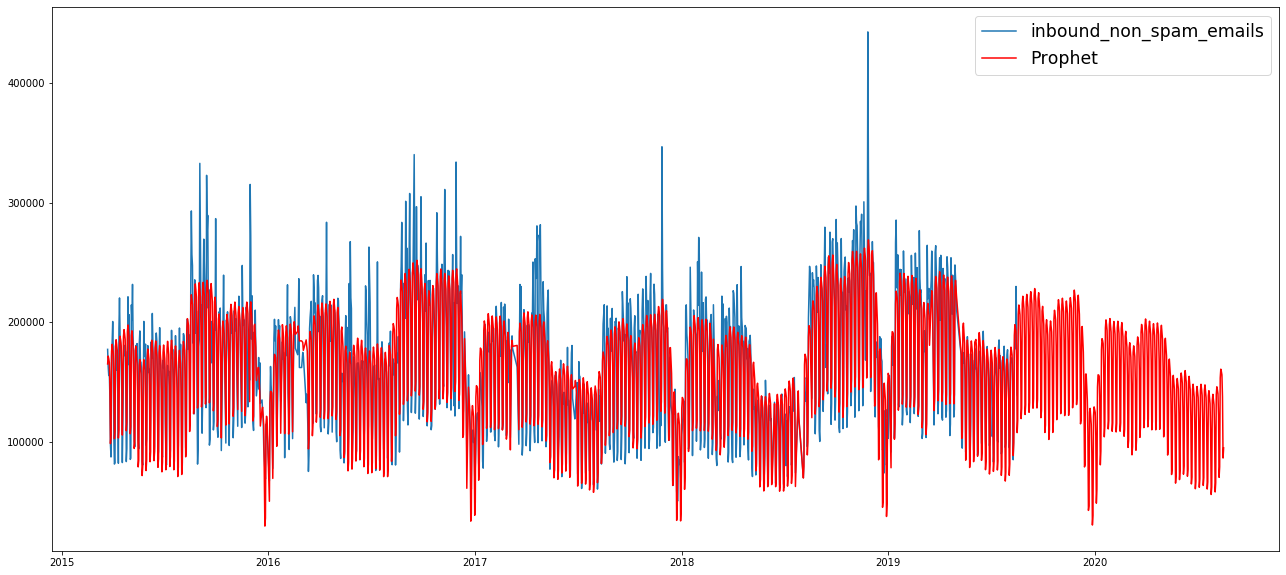

In [22]:
plot(five_att,prediction,True)

These attributes looks like it would benefit a higher fit

In [137]:
more_cp = five_att[['time', 'inbound_rejected_emails','inbound_spam_emails']]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


inbound_rejected_emails


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


inbound_spam_emails


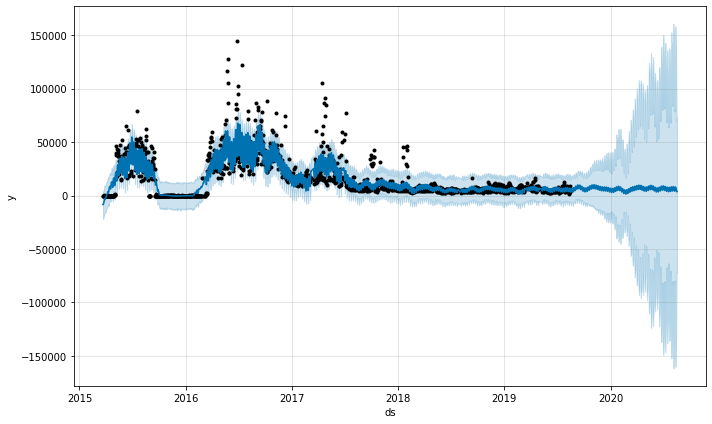

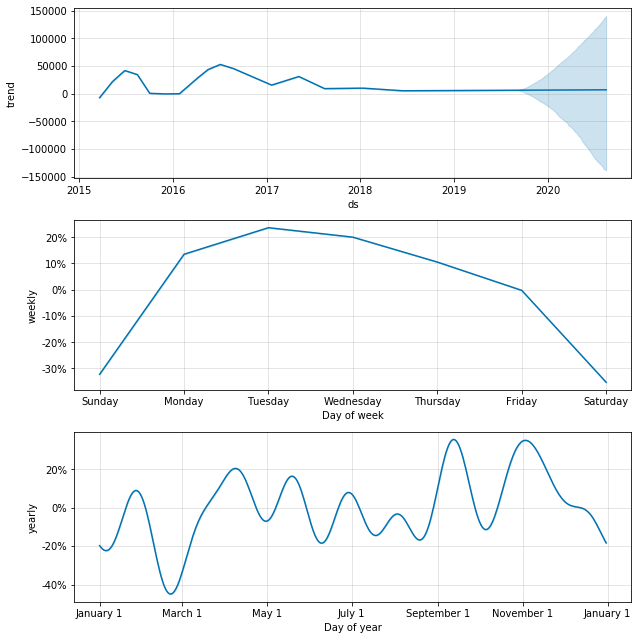

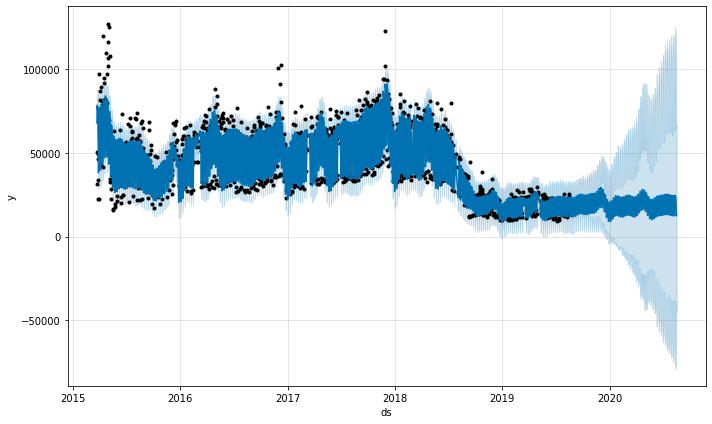

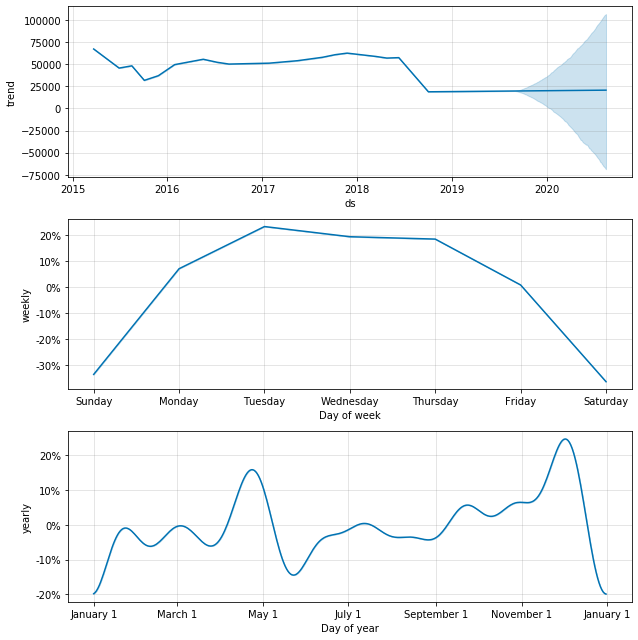

In [138]:
prediction_morecp = send_prediction(more_cp,.7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_rejected_emails
  horizon           mse         rmse          mae      mape  coverage
0 37 days  2.939569e+07  5421.778834  3441.980640  0.467165  0.980392
1 38 days  2.978905e+07  5457.934984  3481.230095  0.470438  0.980392
2 39 days  3.014178e+07  5490.152846  3532.458790  0.475092  0.980392
3 40 days  3.709702e+07  6090.732677  3845.371567  0.491436  0.970588
4 41 days  4.535390e+07  6734.530733  4139.819955  0.501818  0.960784
Performance tail for inbound_rejected_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  2.301362e+08  15170.239543  12118.896520  2.425051       1.0
325 362 days  2.238953e+08  14963.130317  12007.168271  2.433697       1.0
326 363 days  2.248841e+08  14996.135940  11997.251376  2.434985       1.0
327 364 days  2.307570e+08  15190.688959  12095.138282  2.443075       1.0
328 365 days  2.383721e+08  15439.302997  12265.355495  2.459034       1.0


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00


Performance head for inbound_spam_emails
  horizon           mse          rmse           mae      mape  coverage
0 37 days  1.382013e+08  11755.906917   9360.459308  0.308654  0.647059
1 38 days  1.432976e+08  11970.699028   9559.020036  0.318186  0.637255
2 39 days  1.506222e+08  12272.822256   9779.033742  0.328135  0.630719
3 40 days  1.582321e+08  12579.033472  10060.043513  0.339117  0.630719
4 41 days  1.596042e+08  12633.456602  10087.384139  0.338046  0.627451
Performance tail for inbound_spam_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  1.179352e+09  34341.701721  25314.985327  1.283971       1.0
325 362 days  1.172146e+09  34236.610694  25225.756797  1.275897       1.0
326 363 days  1.150058e+09  33912.511022  25045.802871  1.278495       1.0
327 364 days  1.136288e+09  33708.865574  25026.142957  1.286083       1.0
328 365 days  1.146947e+09  33866.604783  25251.853581  1.292900       1.0


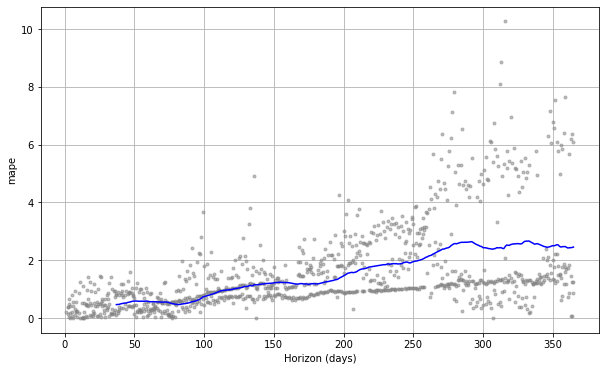

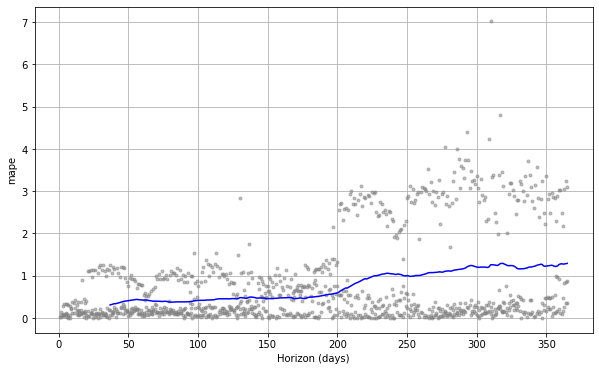

In [74]:
prediction_morecp1 = send_predictionMAPE(more_cp,0.7)

In [139]:
prediction_morecp.head()

time  inbound_rejected_emails  inbound_spam_emails
0 2015-03-23             -8411.337413         68027.333765
1 2015-03-24             -8454.577182         78553.285560
2 2015-03-25             -7550.427661         75625.352826
3 2015-03-26             -6360.901689         74763.325617
4 2015-03-27             -5208.501371         62867.598275

In [140]:
print_each_attr(prediction_morecp,False)

Filling 0s in the dataset for the 5 Attributes

In [25]:
prediction1.head()

time  emails_received   emails_sent  inbound_rejected_emails  \
0 2015-03-23    423982.045313  44428.326605             -4790.769916   
1 2015-03-24    434860.967468  45412.092737             -4802.157310   
2 2015-03-25    429912.511096  44680.894666             -4184.537435   
3 2015-03-26    414762.133157  42518.157779             -3511.308578   
4 2015-03-27    358642.608717  35285.973897             -2778.864206   

   inbound_spam_emails  inbound_non_spam_emails  
0         66334.413562            165264.049518  
1         76482.514322            171830.367811  
2         73770.969850            169592.772675  
3         72976.251137            166442.601478  
4         61568.634687            148507.362922

In [148]:
cbt, cbt2 = fill_zero(five_att[['time','emails_received','emails_sent','inbound_non_spam_emails']],prediction1[['time','emails_received','emails_sent','inbound_non_spam_emails']])

C:\Users\augus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\augus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


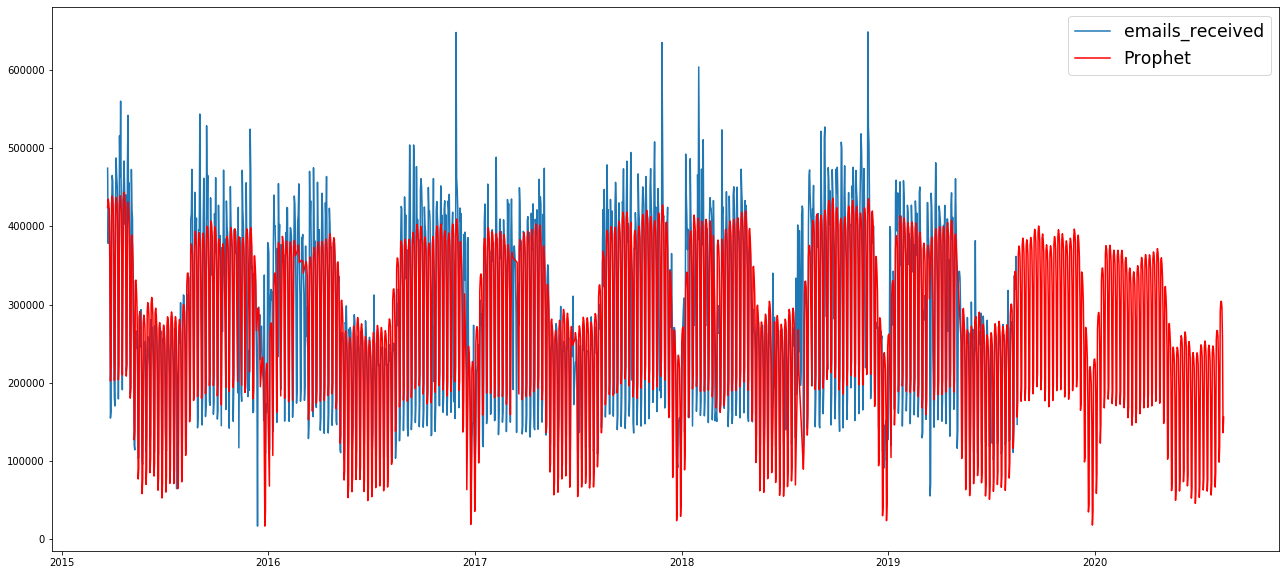

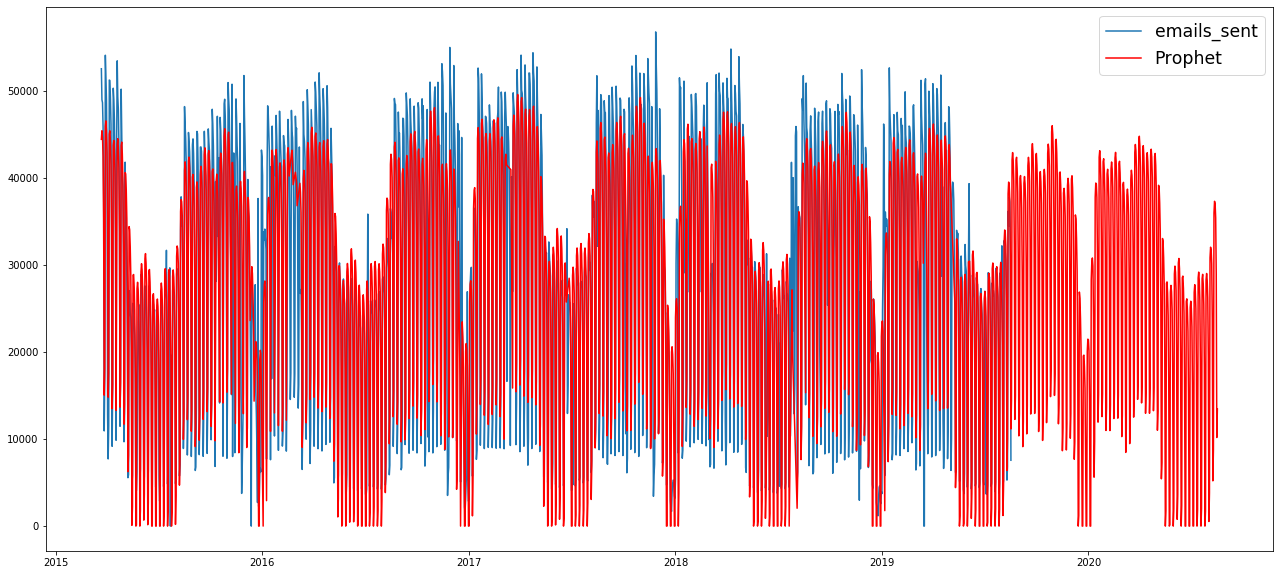

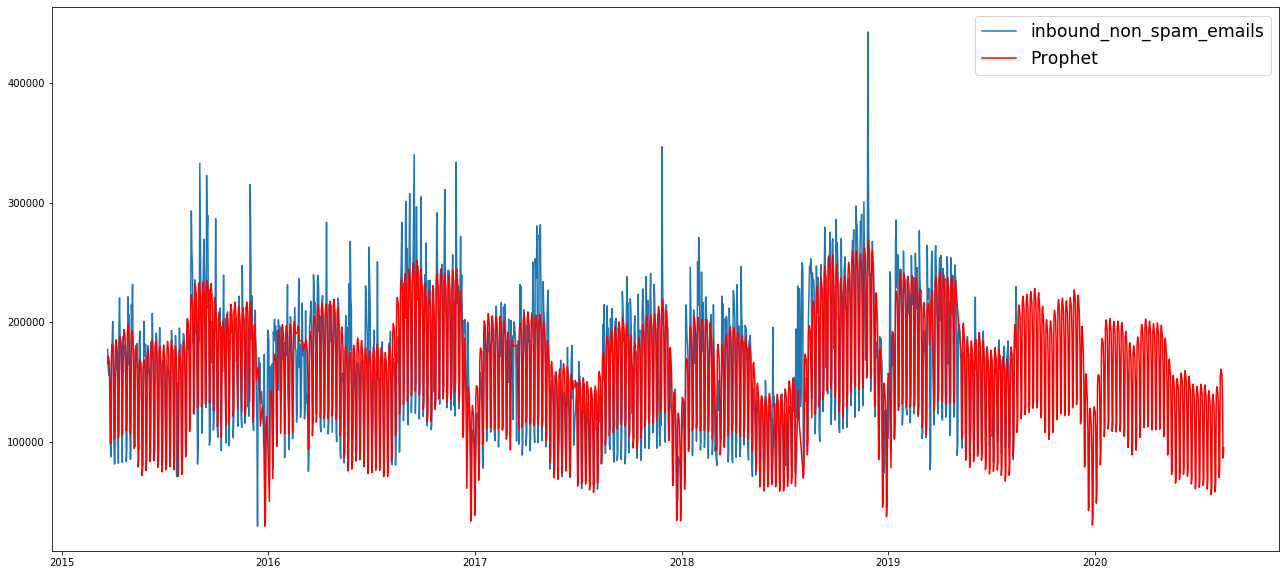

In [149]:
plot(cbt,cbt2,False)

In [150]:
fill1,fill2 = fill_zero(five_att[['time', 'inbound_rejected_emails','inbound_spam_emails']],prediction_morecp)

C:\Users\augus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\augus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


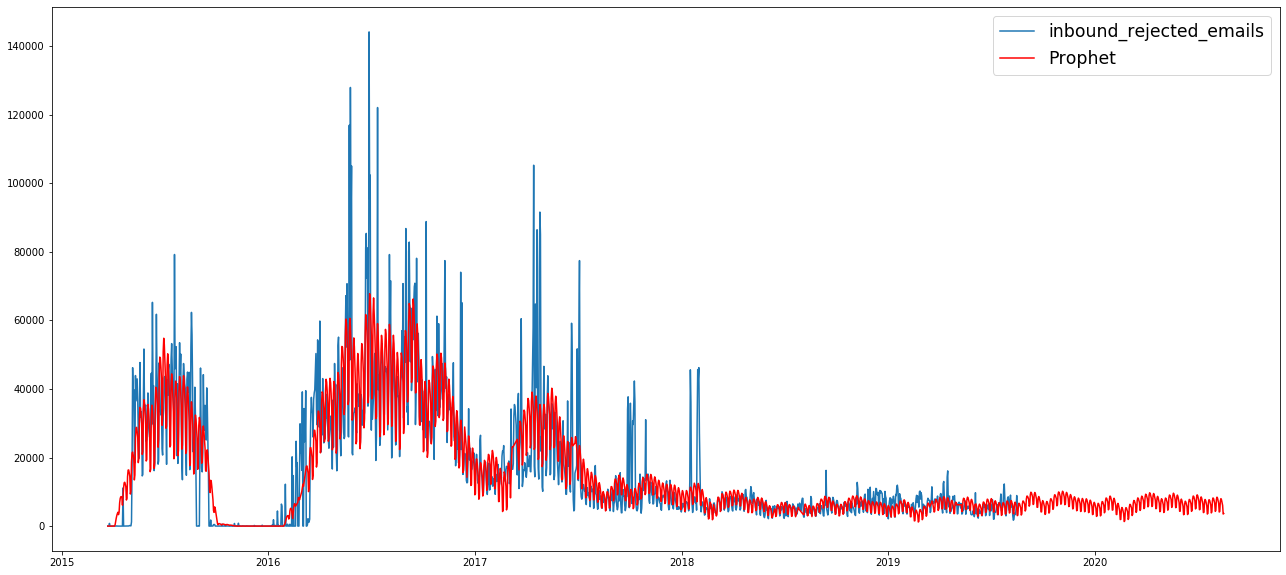

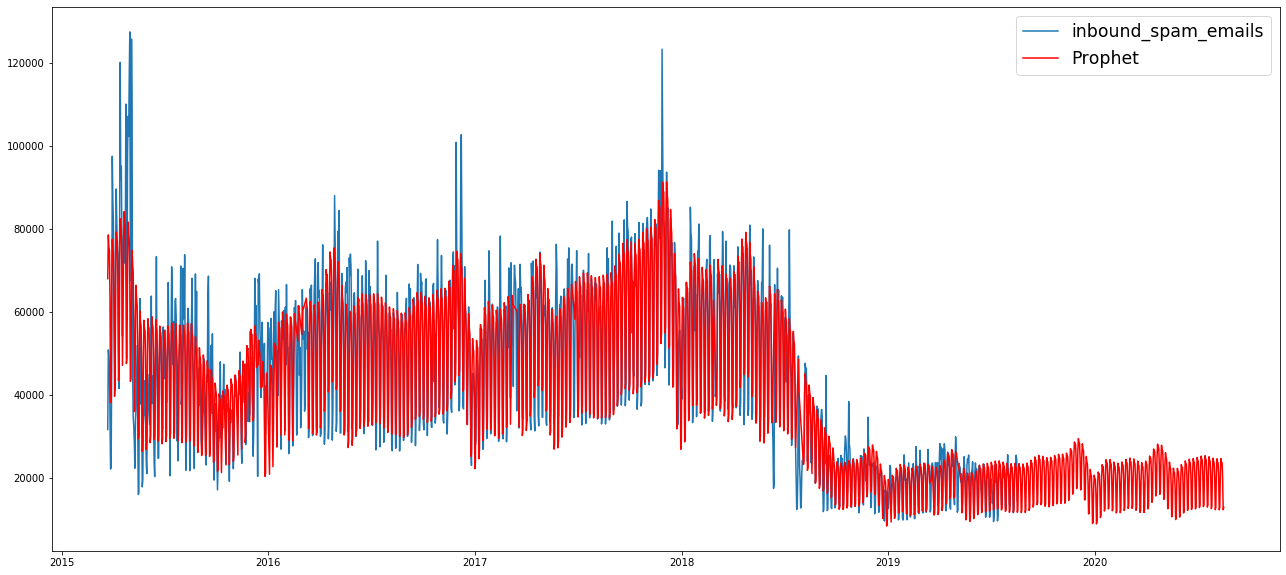

In [151]:
plot(fill1,fill2,False)

This is what the prediction looks like when the negative values are capped at 0 and what the dataset looks like when the missing data are filled with predicted values

Prediction for other attributes

In [152]:
other = pick_your_poison(2)

You picked overall data


In [153]:
other.head()

time  1day_active_users  1day_imap_users  \
0  2015-03-23 00:00:00-04:00            19687.0          10463.0   
1  2015-03-24 00:00:00-04:00            19437.0          10510.0   
2  2015-03-25 00:00:00-04:00            19520.0          10453.0   
3  2015-03-26 00:00:00-04:00            19335.0          10496.0   
4  2015-03-27 00:00:00-04:00            18768.0          10419.0   

   1day_pop_users  1day_webmail_users  30day_active_users  30day_imap_users  \
0           214.0             12300.0             23980.0           12339.0   
1           214.0             12247.0             24025.0           12336.0   
2           212.0             12158.0             24045.0           12357.0   
3           213.0             11713.0             24074.0           12365.0   
4           204.0             10102.0             24079.0           12340.0   

   30day_pop_users  30day_webmail_users  7day_active_users  ...  \
0            265.0              21780.0            22329.0  ...   
1            264.0              21834.0            22364.0  ...   
2            262.0              21862.0            22383.0  ...   
3            263.0              21897.0            22370.0  ...   
4            262.0              21890.0            22395.0  ...   

   inbound_non_spam_emails  inbound_rejected_emails  inbound_rerouted_emails  \
0                 177446.0                      2.0                   7064.0   
1                 163005.0                      6.0                   6143.0   
2                 155603.0                      6.0                   6610.0   
3                 158907.0                    790.0                   7267.0   
4                 137505.0                     13.0                   5983.0   

   inbound_spam_emails  inbound_unencrypted_emails  outbound_delivered_emails  \
0              31718.0                    131902.0                        0.0   
1              50873.0                    128023.0                        0.0   
2              49373.0                    130719.0                        0.0   
3              46494.0                    120764.0                        0.0   
4              34066.0                    104999.0                        0.0   

   outbound_encrypted_emails  outbound_rejected_emails  \
0                    26144.0                     667.0   
1                    23205.0                    1330.0   
2                    23037.0                     847.0   
3                    22764.0                     863.0   
4                    18333.0                     487.0   

   outbound_rerouted_emails  outbound_unencrypted_emails  
0                   26072.0                         22.0  
1                   23136.0                         15.0  
2                   22959.0                        229.0  
3                   22672.0                         33.0  
4                   18242.0                          7.0  

[5 rows x 28 columns]

In [154]:
other = other[['time','1day_active_users','emails_exchanged','inbound_delivered_emails','outbound_rejected_emails']]

In [155]:
other = drop_zero(other)

time                        2015-03-23 00:00:00-04:00
1day_active_users                                7235
emails_exchanged                                76643
inbound_delivered_emails                        67703
outbound_rejected_emails                           25
dtype: object


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1day_active_users


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


emails_exchanged


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


inbound_delivered_emails


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


outbound_rejected_emails


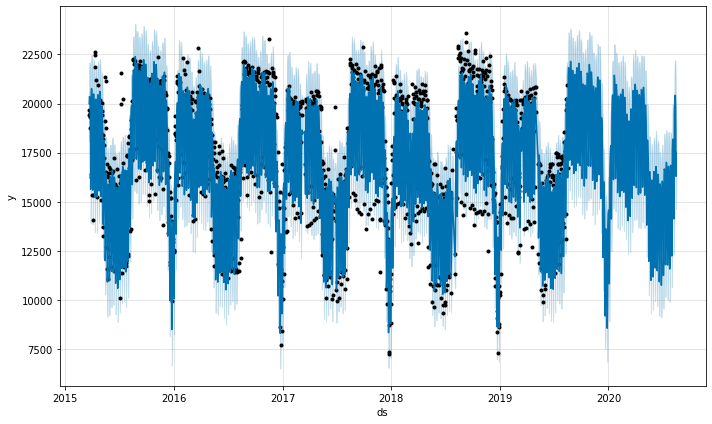

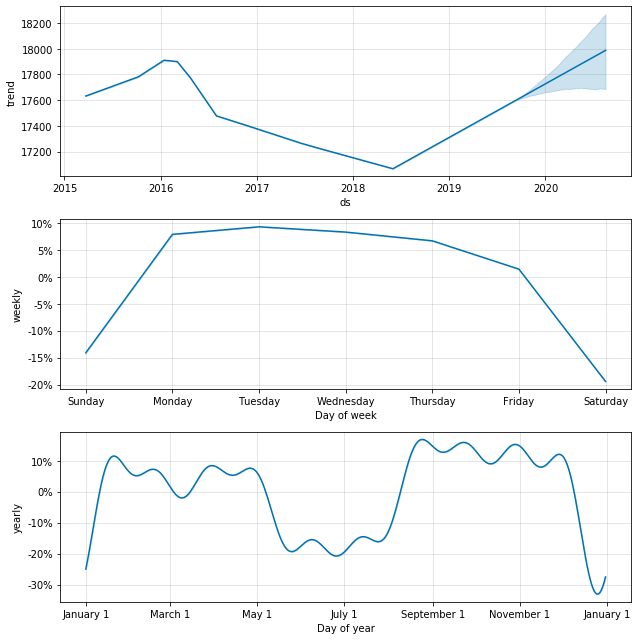

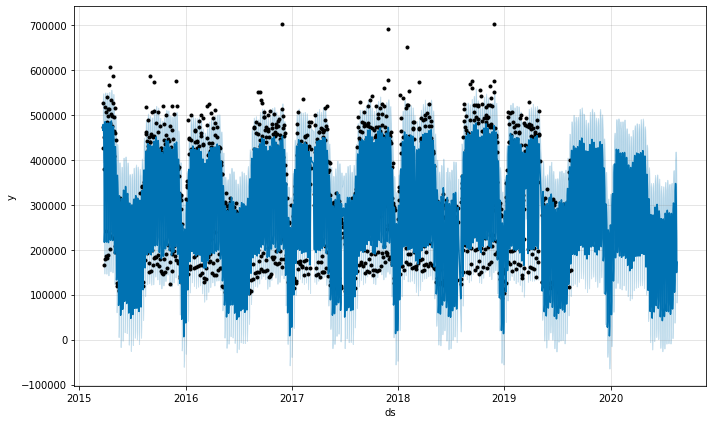

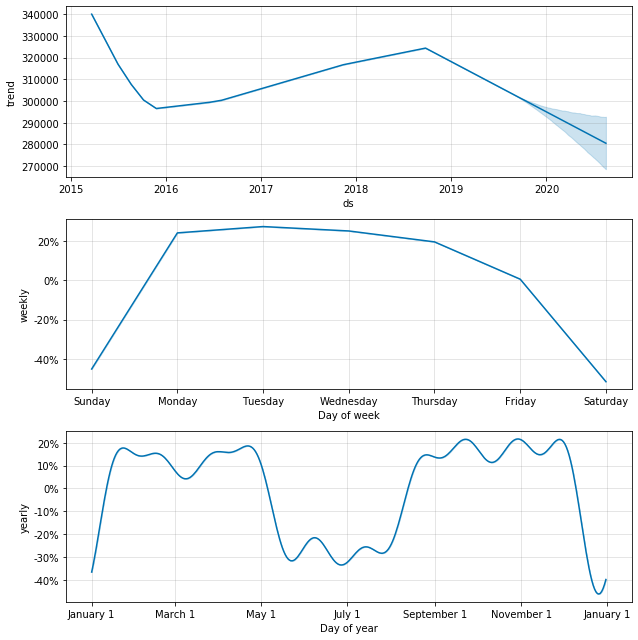

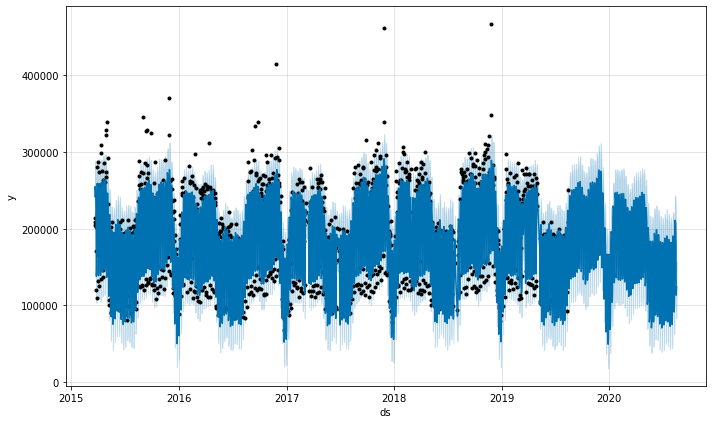

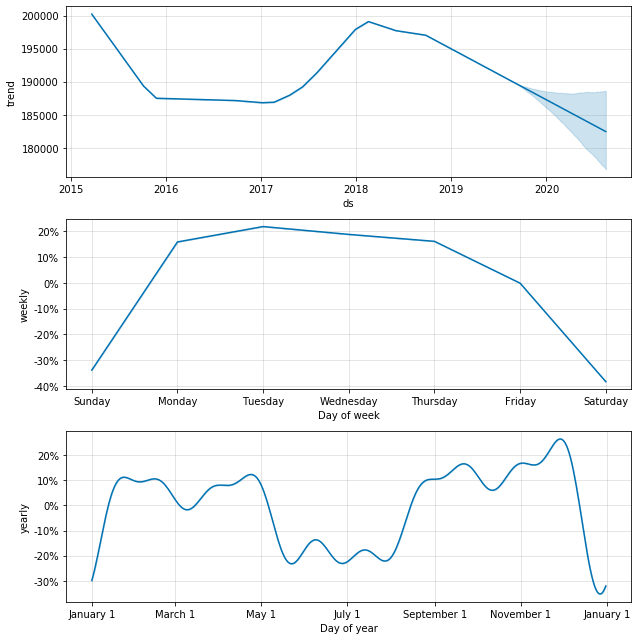

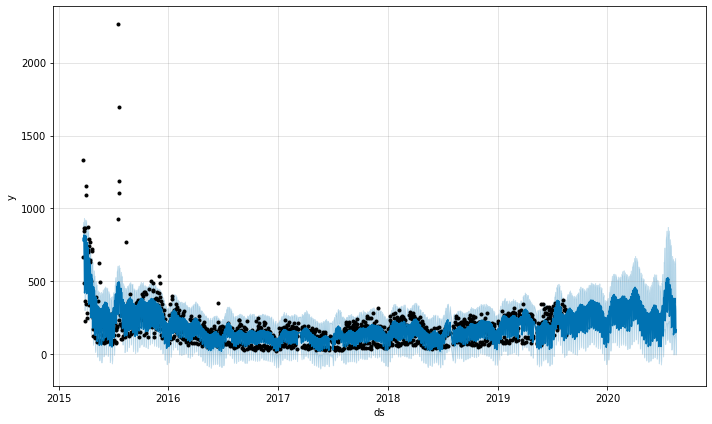

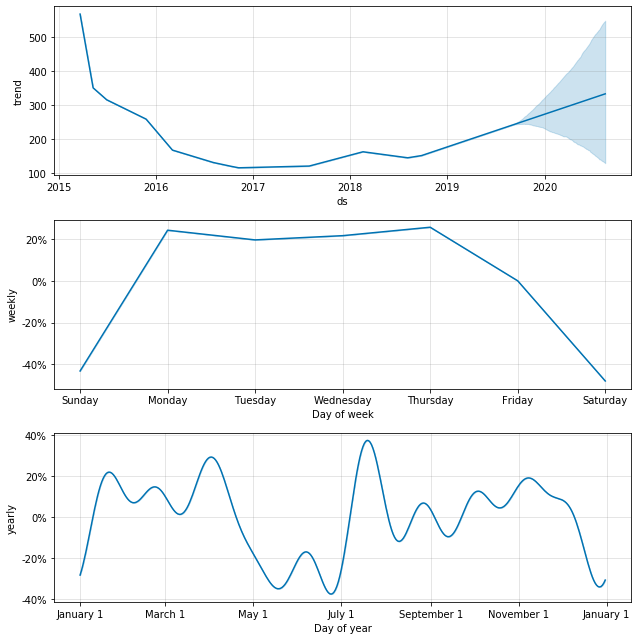

In [156]:
other_prediction = send_prediction(other,0.2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for 1day_active_users
  horizon           mse         rmse          mae      mape  coverage
0 37 days  2.321136e+06  1523.527592  1214.494494  0.066994  0.745098
1 38 days  2.325481e+06  1524.952750  1215.904135  0.067060  0.745098
2 39 days  2.362555e+06  1537.060593  1222.442319  0.067798  0.738562
3 40 days  2.487647e+06  1577.227618  1244.250215  0.069580  0.738562
4 41 days  2.504270e+06  1582.488480  1248.805303  0.070569  0.735294
Performance tail for 1day_active_users
     horizon           mse         rmse          mae      mape  coverage
324 361 days  1.961390e+06  1400.496262  1099.122319  0.070272  0.862745
325 362 days  1.917791e+06  1384.843198  1085.606299  0.069079  0.866013
326 363 days  1.859502e+06  1363.635509  1082.031995  0.068296  0.875817
327 364 days  1.806431e+06  1344.035195  1065.095838  0.066462  0.882353
328 365 days  1.764563e+06  1328.368516  1043.338945  0.064427  0.885621


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_exchanged
  horizon           mse          rmse           mae      mape  coverage
0 37 days  3.714582e+09  60947.366947  44499.881988  0.153830  0.803922
1 38 days  3.729731e+09  61071.524448  44813.639451  0.154517  0.803922
2 39 days  3.745484e+09  61200.361017  45063.122103  0.155913  0.803922
3 40 days  3.971926e+09  63023.216128  45900.382974  0.161180  0.797386
4 41 days  3.958461e+09  62916.301722  45813.356211  0.162048  0.803922
Performance tail for emails_exchanged
     horizon           mse          rmse           mae      mape  coverage
324 361 days  3.057584e+09  55295.425644  42413.316748  0.168163  0.882353
325 362 days  3.054617e+09  55268.590086  42377.851957  0.165821  0.882353
326 363 days  3.125301e+09  55904.390225  42824.810418  0.166210  0.885621
327 364 days  3.128738e+09  55935.125948  42752.720703  0.164295  0.892157
328 365 days  3.225653e+09  56794.836286  43241.048662  0.162956  0.892157


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_delivered_emails
  horizon           mse          rmse           mae      mape  coverage
0 37 days  6.423527e+08  25344.677963  19512.721048  0.103301  0.833333
1 38 days  6.421723e+08  25341.119639  19524.354334  0.102970  0.836601
2 39 days  6.436560e+08  25370.375453  19628.251458  0.103849  0.843137
3 40 days  6.825074e+08  26124.843238  19973.051534  0.106374  0.833333
4 41 days  6.905772e+08  26278.835433  20209.079237  0.107938  0.833333
Performance tail for inbound_delivered_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  1.533926e+09  39165.373090  29692.854406  0.165570  0.699346
325 362 days  1.500193e+09  38732.327836  29385.934013  0.162936  0.709150
326 363 days  1.506635e+09  38815.398752  29792.600151  0.164395  0.689542
327 364 days  1.478500e+09  38451.263965  29899.131500  0.164477  0.679739
328 365 days  1.473572e+09  38387.134517  29969.404170  0.163500  0.679739


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00


Performance head for outbound_rejected_emails
  horizon          mse       rmse        mae      mape  coverage
0 37 days  2009.809544  44.830899  35.408893  0.223555       1.0
1 38 days  1983.361768  44.534950  35.029127  0.221169       1.0
2 39 days  1968.979405  44.373183  34.651495  0.220190       1.0
3 40 days  2003.170397  44.756792  34.991485  0.220053       1.0
4 41 days  2018.652426  44.929416  35.219378  0.225186       1.0
Performance tail for outbound_rejected_emails
     horizon          mse       rmse        mae      mape  coverage
324 361 days  6514.998097  80.715538  67.069257  0.392134  0.924837
325 362 days  6297.070577  79.354084  65.817289  0.386955  0.931373
326 363 days  6373.063356  79.831468  66.336810  0.387825  0.931373
327 364 days  6533.972685  80.832993  66.948279  0.385926  0.931373
328 365 days  6592.708910  81.195498  67.506651  0.382396  0.931373


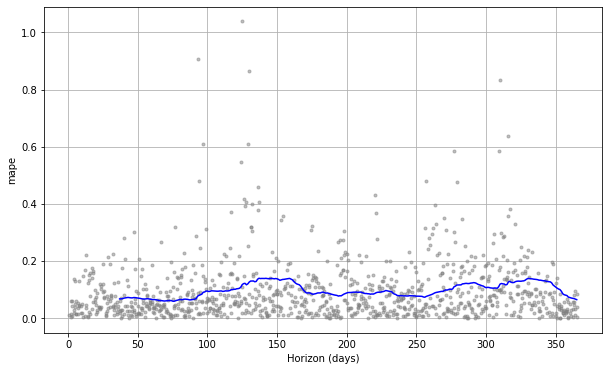

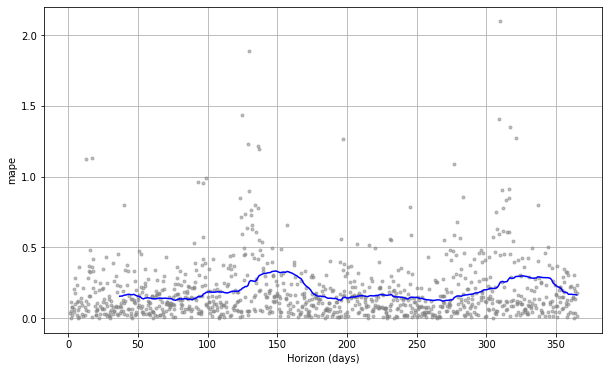

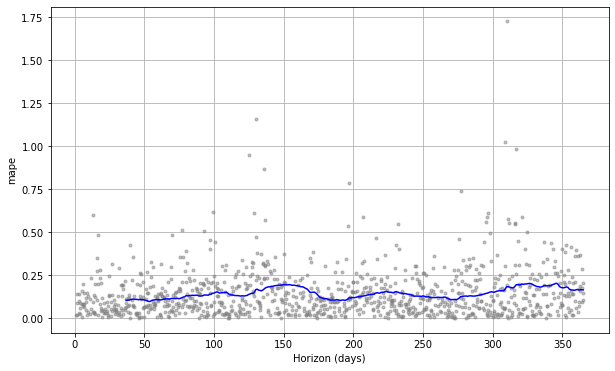

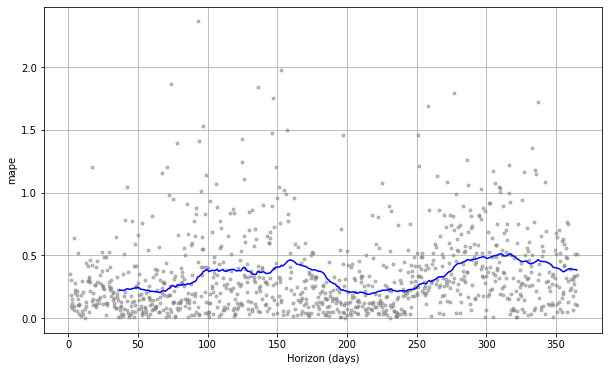

In [35]:
other_prediction1 = send_predictionMAPE(other,0.2)

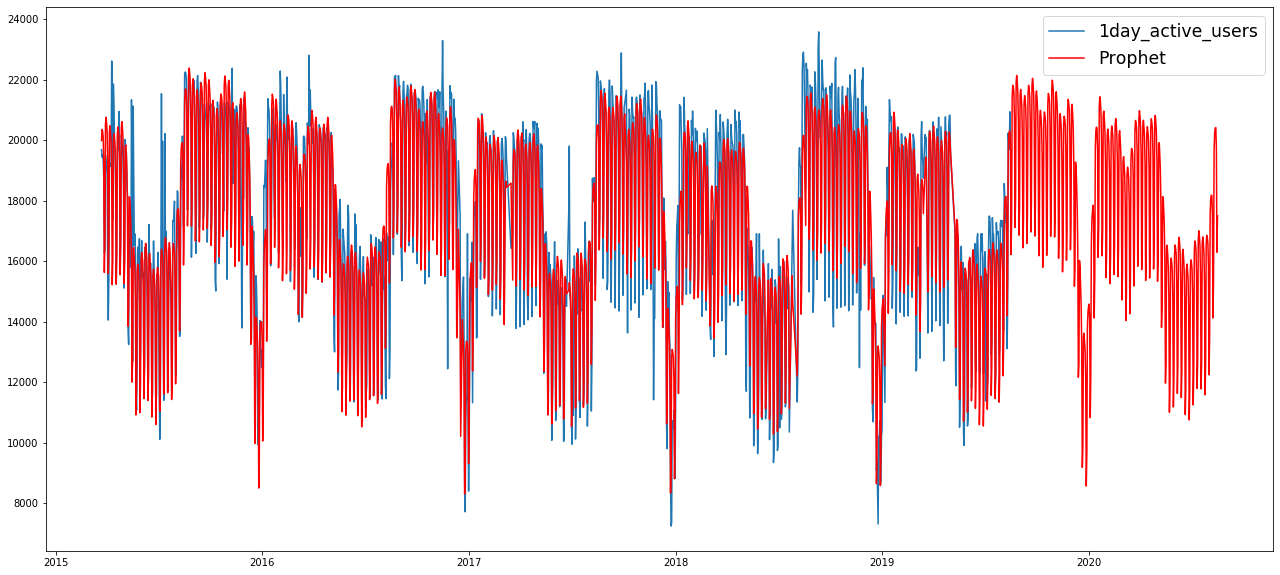

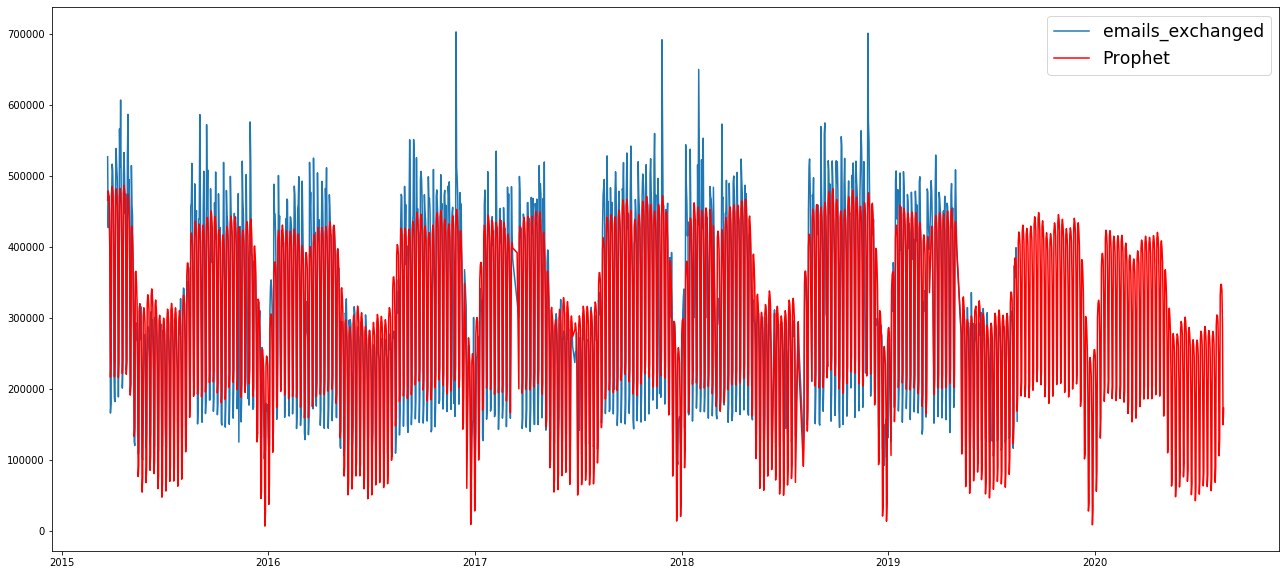

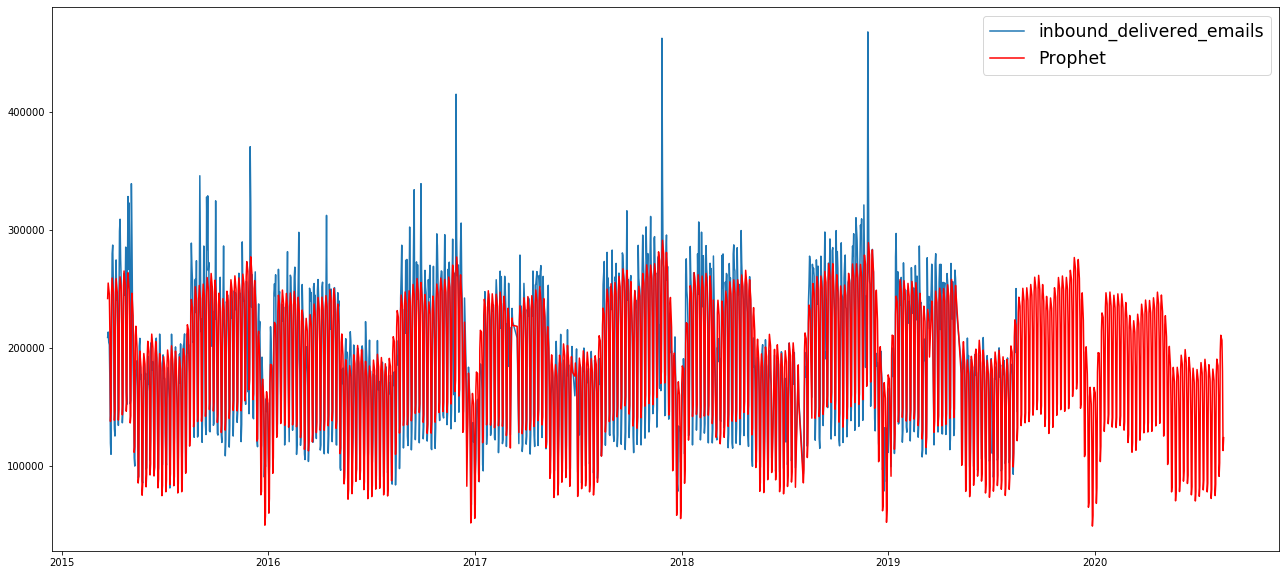

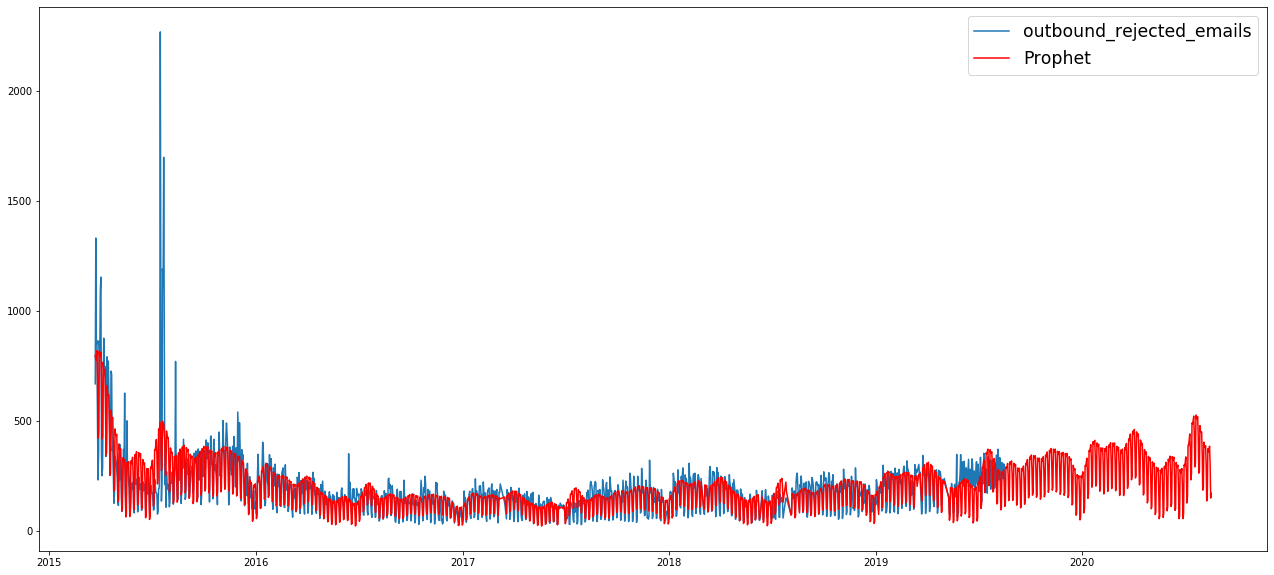

In [158]:
plot(other,other_prediction, True)

In [157]:
print_each_attr(other_prediction,False)

In [159]:
other_prediction.head()

time  1day_active_users  emails_exchanged  inbound_delivered_emails  \
0 2015-03-23       19990.319523     465860.686822             241907.191897   
1 2015-03-24       20355.988854     478845.731507             255002.879140   
2 2015-03-25       20289.342496     472996.501618             249943.471948   
3 2015-03-26       20095.123411     455612.827804             245456.438168   
4 2015-03-27       19244.293008     392364.042214             213742.765611   

   outbound_rejected_emails  
0                795.859042  
1                774.939376  
2                791.300907  
3                817.892942  
4                679.681421

Fill 0s for other attributes

In [160]:
other1,pred1 = fill_zero(other,other_prediction)

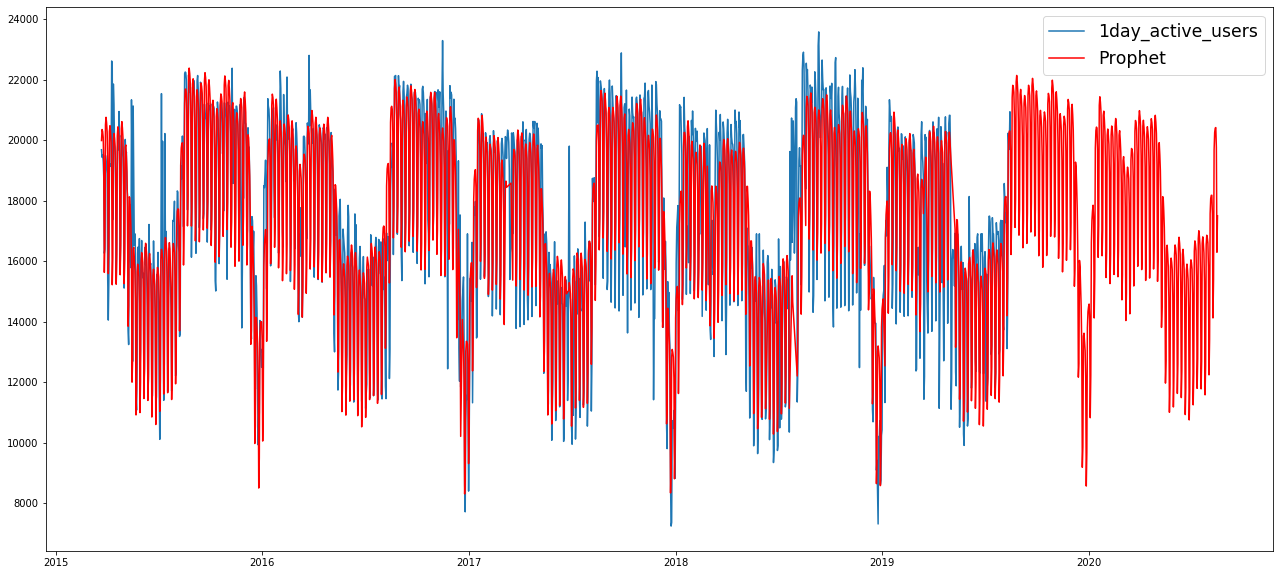

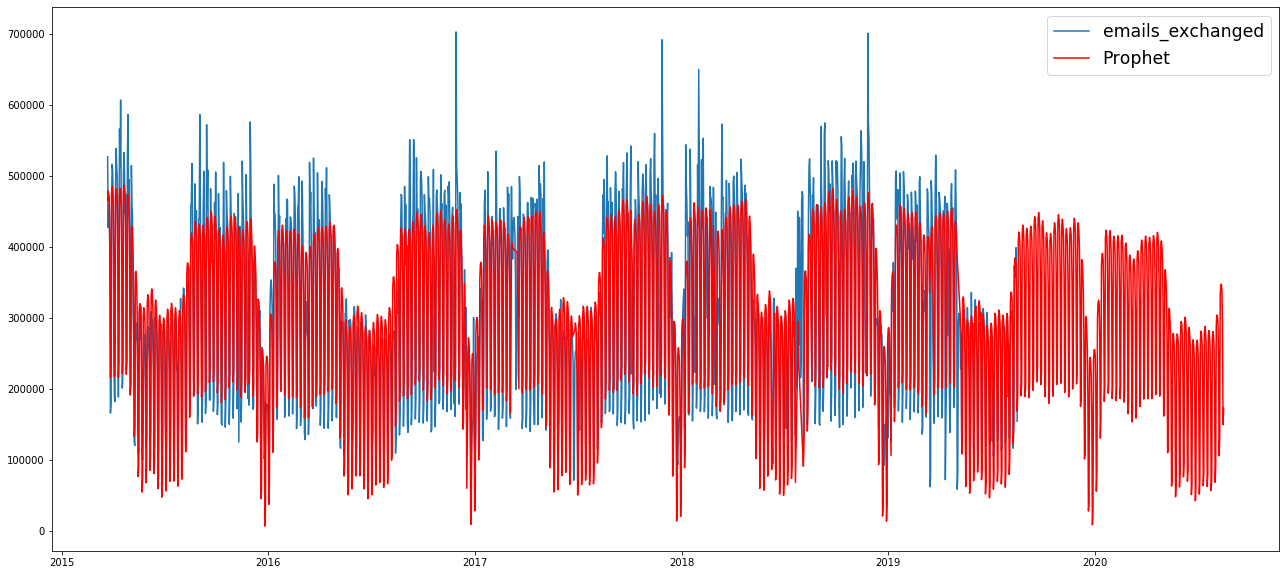

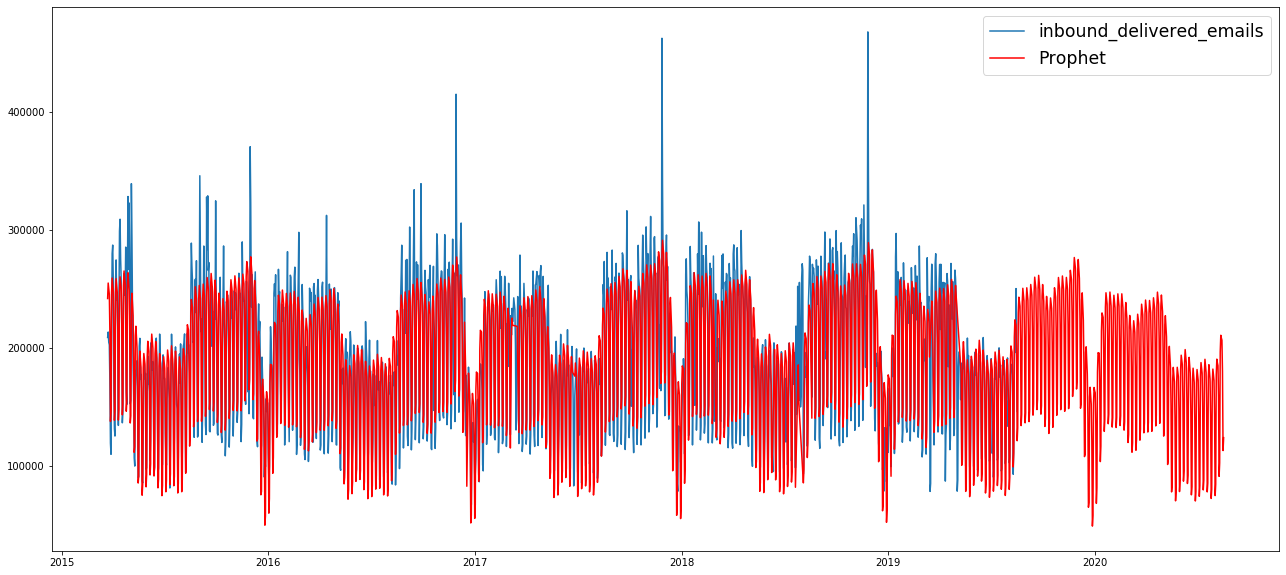

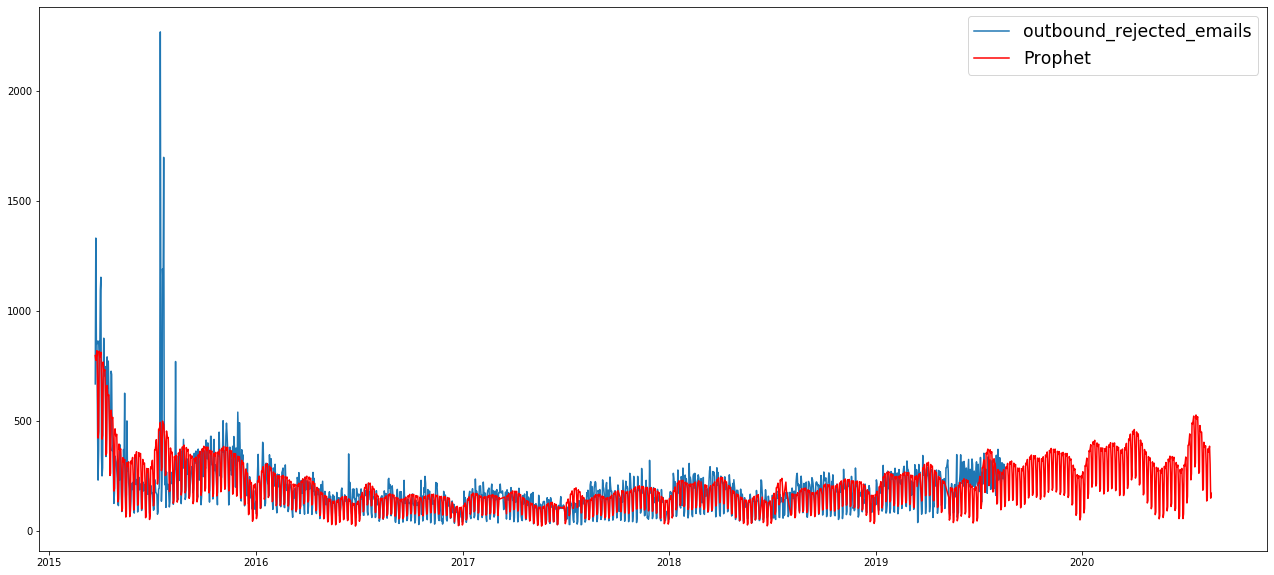

In [161]:
plot(other1,pred1,False)

Not important down below but keeping it in case I would like to mess with it later.

In [75]:
print_each_attr(other,True)
print_each_attr(five_att,True)

In [128]:
ire = ire.reindex()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 9 forecasts with cutoffs between 2018-04-04 00:00:00 and 2019-05-09 00:00:00


Performance head for inbound_rejected_emails
  horizon           mse         rmse          mae      mape  coverage
0 10 days  2.141318e+06  1463.324371  1131.404931  0.212377  0.657727
1 11 days  2.315104e+06  1521.546467  1172.034520  0.219354  0.620690
2 12 days  3.957047e+06  1989.232761  1316.894096  0.227611  0.604087
3 13 days  4.012973e+06  2003.240668  1337.487500  0.229877  0.618135
4 14 days  3.762380e+06  1939.685420  1280.767430  0.217729  0.636015
Performance tail for inbound_rejected_emails
    horizon           mse         rmse          mae      mape  coverage
86  96 days  1.919123e+07  4380.779986  3449.376470  0.723850  0.854406
87  97 days  2.042690e+07  4519.613254  3522.440403  0.731210  0.858238
88  98 days  2.080517e+07  4561.268447  3523.463395  0.723064  0.873563
89  99 days  1.978989e+07  4448.583082  3361.439049  0.705463  0.904215
90 100 days  1.978641e+07  4448.191923  3362.627837  0.694464  0.908046


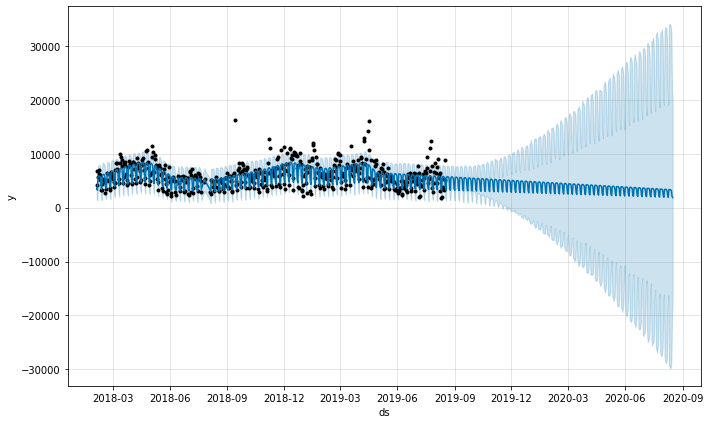

In [153]:
ire_pred = timeprediction_cut_off_attributes(ire, 'inbound_rejected_emails')